****

In [2]:
# import the relevant libraries

import numpy as np
from pathlib import Path
import random
import torch
import torchvision
from torchvision import transforms
import tqdm

In [3]:
#kaggle datasets download -d yusrashereen/5g-data
data_dir = Path("/kaggle/input/5g-data/5G Data")
list(data_dir.iterdir())

[PosixPath('/kaggle/input/5g-data/5G Data/64QAM'),
 PosixPath('/kaggle/input/5g-data/5G Data/32QAM'),
 PosixPath('/kaggle/input/5g-data/5G Data/16QAM'),
 PosixPath('/kaggle/input/5g-data/5G Data/8QAM'),
 PosixPath('/kaggle/input/5g-data/5G Data/4QAM')]

### Dataset Normalization

In [4]:
#calulating mean and std of this image dataset
def calculate_dataset_mean(dataloader): 
    images, labels = next(iter(dataloader))
    # shape of images = [batch,channel,width,height]
    return images.mean([0,2,3])

def calculate_dataset_std(dataloader):
    images, labels = next(iter(dataloader))
    # shape of images = [batch,channel,width,height]
    return images.std([0,2,3])

raw_dataset_transforms = transforms.Compose([
        transforms.Resize(255), 
        transforms.CenterCrop(225), 
        transforms.ToTensor()
    ])

raw_dataset = torchvision.datasets.ImageFolder(root = str(data_dir), transform=raw_dataset_transforms)
raw_dataloader = torch.utils.data.DataLoader(raw_dataset, batch_size=len(raw_dataset))
print(f"mean = {calculate_dataset_mean(raw_dataloader)} and std = {calculate_dataset_std(raw_dataloader)}")

mean = tensor([0.2825, 0.5943, 0.7537]) and std = tensor([0.2438, 0.1855, 0.2682])


### Creating the dataloaders
* Compose transformations for the training and validation datasets
* Create datasets with the appropicate transformations applied
* Create dataloaders using the datasets

In [5]:
# Dataset Configurations
CLASSES = ["4QAM","8QAM","16QAM","32QAM","64QAM"]
NUMBER_OF_CLASSES = len(CLASSES)
SHUFFLE = True
VALIDATION_SIZE = 0.2
RESIZE = 64

In [6]:
# Compose image transformations for the training and validation datasets

normalize = transforms.Normalize(
        mean=calculate_dataset_mean(raw_dataloader),
        std=calculate_dataset_std(raw_dataloader),
    )

training_transform = transforms.Compose([
        transforms.RandomRotation(30),
        transforms.Resize(RESIZE),
        transforms.CenterCrop(RESIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
] )

validation_transform = transforms.Compose(
    [transforms.Resize(RESIZE),
     transforms.CenterCrop(RESIZE),         
     transforms.ToTensor(),
     normalize,
    ])

In [7]:
# Create the datasets and apply the relavant transformations.
# At this point both datasets contain all the data from the data directory.
# I will split the data later using a data sampler.

training_dataset = torchvision.datasets.ImageFolder(
    root = str(data_dir),
    transform = training_transform,
)
validation_dataset = torchvision.datasets.ImageFolder(
    root = str(data_dir),
    transform = validation_transform
)

# Check dataset normalization. 
# Mean should be close to 0 and std should be close to 1 after normalization
normalized_dataloader = torch.utils.data.DataLoader(
    validation_dataset, 
    batch_size=len(validation_dataset),
    )

print(f"mean = {calculate_dataset_mean(normalized_dataloader)}",
      f"std = {calculate_dataset_std(normalized_dataloader)}")

mean = tensor([ 0.0144, -0.0146, -0.0027]) std = tensor([1.0078, 1.0083, 1.0048])


In [8]:
# Use samplers to split the data between the training and validation.
split = int(np.floor(len(training_dataset) * VALIDATION_SIZE))
indices = list(range(len(training_dataset)))
if SHUFFLE:
    random.shuffle(indices)

validation_indices, training_indices = indices[: split], indices[split :]

training_sampler = torch.utils.data.sampler.SubsetRandomSampler(training_indices)
validation_sampler = torch.utils.data.sampler.SubsetRandomSampler(validation_indices)

In [9]:
# Dataloader Configurations
BATCH_SIZE = 4
NUMBER_OF_WORKERS = 2
PIN_MEMORY = False

In [10]:
# Create the dataloaders
training_dataloader = torch.utils.data.DataLoader(
    training_dataset, 
    batch_size=BATCH_SIZE, 
    sampler=training_sampler,
    num_workers=NUMBER_OF_WORKERS, 
    pin_memory=PIN_MEMORY,
    )

validation_dataloader = torch.utils.data.DataLoader(
    training_dataset, 
    batch_size=BATCH_SIZE, 
    sampler=validation_sampler,
    num_workers=NUMBER_OF_WORKERS, 
    pin_memory=PIN_MEMORY,
    )

#### Lets have a look at the data :)

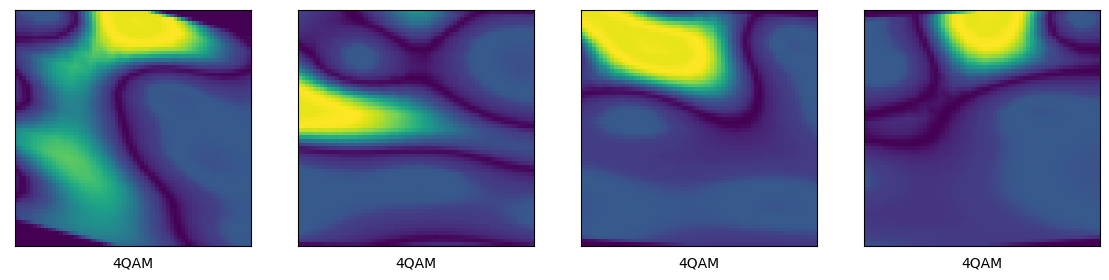

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# display images
for images, labels in training_dataloader:
    fig = plt.figure(figsize = (14, 7))
    for i in range(BATCH_SIZE):
        ax = fig.add_subplot(2, 4, i + 1, xticks = [], yticks = [])
        ax.set_xlabel(f"{CLASSES[labels[i]]}")
        image = images[i][0, :, :]
        plt.imshow(image)
    break

### Training

In [12]:
# Training Configurations
MODEL_NAME = "resnet18"
WEIGHTS = "DEFAULT"
LEARNING_RATE = 0.0001
MOMENTUM = 0.9
NUMBER_OF_EPOCHS = 100
MODEL_SAVE_PATH = "model.pt"

In [13]:
# Initialize a pretrained model
model = torchvision.models.get_model(MODEL_NAME, weights=WEIGHTS)
model.fc = torch.nn.Linear(512, 5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 302MB/s]


In [14]:
# Choose a loss function and an optimazation function
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

#### Now lets train the model

In [15]:
#somewhere to store the training process stats
training_loss_history = []
validation_loss_history = []
validation_accuracy_history = []

# Training and validation loop
for epoch in range(NUMBER_OF_EPOCHS):
    
    model.train()
    training_step_loss = []
    print(f"Epoch {epoch + 1}/{NUMBER_OF_EPOCHS}")
    for data in tqdm.tqdm(training_dataloader, desc="training"):
        features, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        outputs = model(features)
        
        training_loss = criterion(outputs, labels)
        training_loss.backward()
        optimizer.step()
        training_step_loss.append(training_loss.item())
            
    training_epoch_loss = sum(training_step_loss)/len(training_step_loss)
    training_loss_history.append(training_epoch_loss)
    
    model.eval()
    validation_step_loss = []
    correct_predictions = 0 
    for data in tqdm.tqdm(validation_dataloader, desc="validating"):

        features, labels = data
        outputs = model(features)
        correct_predictions += torch.sum(torch.argmax(outputs, axis=1)==labels)
        validation_loss = criterion(outputs, labels)
        validation_step_loss.append(validation_loss.item())

    validation_epoch_loss = sum(validation_step_loss)/len(validation_step_loss)
    validation_loss_history.append(validation_epoch_loss)
    validation_epoch_accuracy = correct_predictions / (len(validation_dataloader) * BATCH_SIZE)
    print(f"Training Loss: {training_epoch_loss:.4f},"
          f"Validation Loss: {validation_epoch_loss:.4f}," 
          f"Validation Acc: {validation_epoch_accuracy:.4f}")
    
    # save model
    if epoch==0 or validation_epoch_accuracy > max(validation_accuracy_history):
        print("Validation loss improved, saving checkpoint.")
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': validation_epoch_loss,
                }, MODEL_SAVE_PATH)
        print("Checkpoint saved")
    validation_accuracy_history.append(validation_epoch_accuracy)
print('Finished Training')

Epoch 1/100


validating: 100%|██████████| 100/100 [00:03<00:00, 29.76it/s]


Training Loss: 1.7706,Validation Loss: 1.8679,Validation Acc: 0.2250
Validation loss improved, saving checkpoint.
Checkpoint saved
Epoch 2/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.64it/s]


Training Loss: 1.7026,Validation Loss: 1.8942,Validation Acc: 0.2125
Epoch 3/100


validating: 100%|██████████| 100/100 [00:03<00:00, 31.41it/s]


Training Loss: 1.6896,Validation Loss: 1.8949,Validation Acc: 0.2050
Epoch 4/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.08it/s]


Training Loss: 1.6993,Validation Loss: 1.7822,Validation Acc: 0.2250
Epoch 5/100


validating: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


Training Loss: 1.6770,Validation Loss: 1.8413,Validation Acc: 0.2325
Validation loss improved, saving checkpoint.
Checkpoint saved
Epoch 6/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.61it/s]


Training Loss: 1.6635,Validation Loss: 1.8053,Validation Acc: 0.2325
Epoch 7/100


validating: 100%|██████████| 100/100 [00:03<00:00, 28.52it/s]


Training Loss: 1.6663,Validation Loss: 1.7793,Validation Acc: 0.1950
Epoch 8/100


validating: 100%|██████████| 100/100 [00:03<00:00, 27.28it/s]


Training Loss: 1.6625,Validation Loss: 1.7788,Validation Acc: 0.2250
Epoch 9/100


validating: 100%|██████████| 100/100 [00:03<00:00, 29.96it/s]


Training Loss: 1.6780,Validation Loss: 1.7817,Validation Acc: 0.1850
Epoch 10/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.99it/s]


Training Loss: 1.6461,Validation Loss: 1.8520,Validation Acc: 0.1975
Epoch 11/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.41it/s]


Training Loss: 1.6763,Validation Loss: 1.8938,Validation Acc: 0.2100
Epoch 12/100


validating: 100%|██████████| 100/100 [00:03<00:00, 29.70it/s]


Training Loss: 1.6433,Validation Loss: 1.8407,Validation Acc: 0.1975
Epoch 13/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.22it/s]


Training Loss: 1.6604,Validation Loss: 1.7424,Validation Acc: 0.2425
Validation loss improved, saving checkpoint.
Checkpoint saved
Epoch 14/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.12it/s]


Training Loss: 1.6432,Validation Loss: 1.7395,Validation Acc: 0.2125
Epoch 15/100


validating: 100%|██████████| 100/100 [00:03<00:00, 29.88it/s]


Training Loss: 1.6340,Validation Loss: 1.7238,Validation Acc: 0.2250
Epoch 16/100


validating: 100%|██████████| 100/100 [00:03<00:00, 28.47it/s]


Training Loss: 1.6242,Validation Loss: 1.8409,Validation Acc: 0.1775
Epoch 17/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.13it/s]


Training Loss: 1.6323,Validation Loss: 1.7580,Validation Acc: 0.2450
Validation loss improved, saving checkpoint.
Checkpoint saved
Epoch 18/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.45it/s]


Training Loss: 1.6446,Validation Loss: 1.7757,Validation Acc: 0.2300
Epoch 19/100


validating: 100%|██████████| 100/100 [00:03<00:00, 29.63it/s]


Training Loss: 1.6382,Validation Loss: 1.7016,Validation Acc: 0.2475
Validation loss improved, saving checkpoint.
Checkpoint saved
Epoch 20/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.38it/s]


Training Loss: 1.6223,Validation Loss: 1.7626,Validation Acc: 0.2450
Epoch 21/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.42it/s]


Training Loss: 1.6217,Validation Loss: 1.7344,Validation Acc: 0.2175
Epoch 22/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.84it/s]


Training Loss: 1.6089,Validation Loss: 1.7427,Validation Acc: 0.2350
Epoch 23/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.03it/s]


Training Loss: 1.6065,Validation Loss: 1.7718,Validation Acc: 0.2475
Epoch 24/100


validating: 100%|██████████| 100/100 [00:03<00:00, 29.90it/s]


Training Loss: 1.6391,Validation Loss: 1.6890,Validation Acc: 0.2500
Validation loss improved, saving checkpoint.
Checkpoint saved
Epoch 25/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.54it/s]


Training Loss: 1.6081,Validation Loss: 1.7542,Validation Acc: 0.2175
Epoch 26/100


validating: 100%|██████████| 100/100 [00:03<00:00, 29.67it/s]


Training Loss: 1.5993,Validation Loss: 1.8016,Validation Acc: 0.2175
Epoch 27/100


validating: 100%|██████████| 100/100 [00:03<00:00, 29.17it/s]


Training Loss: 1.6097,Validation Loss: 1.7549,Validation Acc: 0.2325
Epoch 28/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.61it/s]


Training Loss: 1.5783,Validation Loss: 1.7974,Validation Acc: 0.2425
Epoch 29/100


validating: 100%|██████████| 100/100 [00:03<00:00, 27.62it/s]


Training Loss: 1.6030,Validation Loss: 1.7297,Validation Acc: 0.2275
Epoch 30/100


validating: 100%|██████████| 100/100 [00:03<00:00, 28.60it/s]


Training Loss: 1.5953,Validation Loss: 1.7866,Validation Acc: 0.2450
Epoch 31/100


validating: 100%|██████████| 100/100 [00:03<00:00, 29.94it/s]


Training Loss: 1.5942,Validation Loss: 1.7447,Validation Acc: 0.2600
Validation loss improved, saving checkpoint.
Checkpoint saved
Epoch 32/100


validating: 100%|██████████| 100/100 [00:03<00:00, 29.34it/s]


Training Loss: 1.5803,Validation Loss: 1.8611,Validation Acc: 0.2250
Epoch 33/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.88it/s]


Training Loss: 1.5857,Validation Loss: 1.7504,Validation Acc: 0.2350
Epoch 34/100


validating: 100%|██████████| 100/100 [00:03<00:00, 28.03it/s]


Training Loss: 1.5699,Validation Loss: 1.7468,Validation Acc: 0.2475
Epoch 35/100


validating: 100%|██████████| 100/100 [00:03<00:00, 29.85it/s]


Training Loss: 1.5759,Validation Loss: 1.7365,Validation Acc: 0.2225
Epoch 36/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.83it/s]


Training Loss: 1.5919,Validation Loss: 1.7562,Validation Acc: 0.2500
Epoch 37/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.77it/s]


Training Loss: 1.5916,Validation Loss: 1.7456,Validation Acc: 0.2450
Epoch 38/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.64it/s]


Training Loss: 1.5810,Validation Loss: 1.7429,Validation Acc: 0.2400
Epoch 39/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.78it/s]


Training Loss: 1.5606,Validation Loss: 1.7475,Validation Acc: 0.2325
Epoch 40/100


validating: 100%|██████████| 100/100 [00:03<00:00, 29.83it/s]


Training Loss: 1.5664,Validation Loss: 1.7861,Validation Acc: 0.2400
Epoch 41/100


validating: 100%|██████████| 100/100 [00:03<00:00, 29.88it/s]


Training Loss: 1.5526,Validation Loss: 1.7798,Validation Acc: 0.2325
Epoch 42/100


validating: 100%|██████████| 100/100 [00:03<00:00, 29.14it/s]


Training Loss: 1.5556,Validation Loss: 1.7618,Validation Acc: 0.2175
Epoch 43/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.14it/s]


Training Loss: 1.5372,Validation Loss: 1.7995,Validation Acc: 0.2475
Epoch 44/100


validating: 100%|██████████| 100/100 [00:03<00:00, 29.86it/s]


Training Loss: 1.5322,Validation Loss: 1.8073,Validation Acc: 0.2375
Epoch 45/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.15it/s]


Training Loss: 1.5434,Validation Loss: 1.8244,Validation Acc: 0.2425
Epoch 46/100


validating: 100%|██████████| 100/100 [00:03<00:00, 31.23it/s]


Training Loss: 1.5530,Validation Loss: 1.7777,Validation Acc: 0.2500
Epoch 47/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.00it/s]


Training Loss: 1.5232,Validation Loss: 1.8413,Validation Acc: 0.2325
Epoch 48/100


validating: 100%|██████████| 100/100 [00:03<00:00, 29.89it/s]


Training Loss: 1.5359,Validation Loss: 1.8875,Validation Acc: 0.2550
Epoch 49/100


validating: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Training Loss: 1.5192,Validation Loss: 1.7455,Validation Acc: 0.2450
Epoch 50/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.58it/s]


Training Loss: 1.4987,Validation Loss: 1.7734,Validation Acc: 0.2650
Validation loss improved, saving checkpoint.
Checkpoint saved
Epoch 51/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.23it/s]


Training Loss: 1.5162,Validation Loss: 1.8957,Validation Acc: 0.2275
Epoch 52/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.95it/s]


Training Loss: 1.5172,Validation Loss: 1.7762,Validation Acc: 0.2550
Epoch 53/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.43it/s]


Training Loss: 1.4933,Validation Loss: 1.8341,Validation Acc: 0.2425
Epoch 54/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.07it/s]


Training Loss: 1.4916,Validation Loss: 1.8616,Validation Acc: 0.2525
Epoch 55/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.36it/s]


Training Loss: 1.4875,Validation Loss: 1.8812,Validation Acc: 0.2575
Epoch 56/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.32it/s]


Training Loss: 1.4717,Validation Loss: 1.8343,Validation Acc: 0.2700
Validation loss improved, saving checkpoint.
Checkpoint saved
Epoch 57/100


validating: 100%|██████████| 100/100 [00:03<00:00, 29.99it/s]


Training Loss: 1.4714,Validation Loss: 1.8275,Validation Acc: 0.2725
Validation loss improved, saving checkpoint.
Checkpoint saved
Epoch 58/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.81it/s]


Training Loss: 1.4605,Validation Loss: 1.9260,Validation Acc: 0.2675
Epoch 59/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.61it/s]


Training Loss: 1.4627,Validation Loss: 1.8243,Validation Acc: 0.2600
Epoch 60/100


validating: 100%|██████████| 100/100 [00:03<00:00, 27.55it/s]


Training Loss: 1.4725,Validation Loss: 1.8385,Validation Acc: 0.2550
Epoch 61/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.39it/s]


Training Loss: 1.4640,Validation Loss: 1.8832,Validation Acc: 0.2700
Epoch 62/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.78it/s]


Training Loss: 1.4188,Validation Loss: 1.8511,Validation Acc: 0.2400
Epoch 63/100


validating: 100%|██████████| 100/100 [00:03<00:00, 28.31it/s]


Training Loss: 1.4237,Validation Loss: 1.8917,Validation Acc: 0.2775
Validation loss improved, saving checkpoint.
Checkpoint saved
Epoch 64/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.61it/s]


Training Loss: 1.4408,Validation Loss: 1.8513,Validation Acc: 0.2825
Validation loss improved, saving checkpoint.
Checkpoint saved
Epoch 65/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.34it/s]


Training Loss: 1.4140,Validation Loss: 2.0064,Validation Acc: 0.2450
Epoch 66/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.22it/s]


Training Loss: 1.4402,Validation Loss: 1.8646,Validation Acc: 0.2450
Epoch 67/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.31it/s]


Training Loss: 1.3975,Validation Loss: 1.9369,Validation Acc: 0.2725
Epoch 68/100


validating: 100%|██████████| 100/100 [00:03<00:00, 29.70it/s]


Training Loss: 1.3603,Validation Loss: 1.9679,Validation Acc: 0.2525
Epoch 69/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.83it/s]


Training Loss: 1.3791,Validation Loss: 1.8780,Validation Acc: 0.2550
Epoch 70/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.23it/s]


Training Loss: 1.3944,Validation Loss: 1.8681,Validation Acc: 0.2800
Epoch 71/100


validating: 100%|██████████| 100/100 [00:03<00:00, 28.01it/s]


Training Loss: 1.3880,Validation Loss: 1.9000,Validation Acc: 0.2575
Epoch 72/100


validating: 100%|██████████| 100/100 [00:03<00:00, 29.92it/s]


Training Loss: 1.3704,Validation Loss: 1.8112,Validation Acc: 0.2725
Epoch 73/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.13it/s]


Training Loss: 1.3549,Validation Loss: 1.9251,Validation Acc: 0.2575
Epoch 74/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.56it/s]


Training Loss: 1.3707,Validation Loss: 1.9101,Validation Acc: 0.2625
Epoch 75/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.13it/s]


Training Loss: 1.3120,Validation Loss: 2.1414,Validation Acc: 0.2400
Epoch 76/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.38it/s]


Training Loss: 1.3589,Validation Loss: 1.9484,Validation Acc: 0.2325
Epoch 77/100


validating: 100%|██████████| 100/100 [00:03<00:00, 29.83it/s]


Training Loss: 1.3567,Validation Loss: 1.9067,Validation Acc: 0.2775
Epoch 78/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.87it/s]


Training Loss: 1.3034,Validation Loss: 1.8490,Validation Acc: 0.2725
Epoch 79/100


validating: 100%|██████████| 100/100 [00:03<00:00, 29.32it/s]


Training Loss: 1.3333,Validation Loss: 1.8896,Validation Acc: 0.2925
Validation loss improved, saving checkpoint.
Checkpoint saved
Epoch 80/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.18it/s]


Training Loss: 1.3028,Validation Loss: 1.8850,Validation Acc: 0.3150
Validation loss improved, saving checkpoint.
Checkpoint saved
Epoch 81/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.10it/s]


Training Loss: 1.3020,Validation Loss: 1.9479,Validation Acc: 0.2725
Epoch 82/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.04it/s]


Training Loss: 1.2923,Validation Loss: 2.0924,Validation Acc: 0.2600
Epoch 83/100


validating: 100%|██████████| 100/100 [00:03<00:00, 29.76it/s]


Training Loss: 1.2718,Validation Loss: 1.9336,Validation Acc: 0.3025
Epoch 84/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.07it/s]


Training Loss: 1.2683,Validation Loss: 2.0345,Validation Acc: 0.2825
Epoch 85/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.56it/s]


Training Loss: 1.2681,Validation Loss: 2.1105,Validation Acc: 0.2525
Epoch 86/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.35it/s]


Training Loss: 1.2096,Validation Loss: 2.0071,Validation Acc: 0.2175
Epoch 87/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.29it/s]


Training Loss: 1.2629,Validation Loss: 1.9105,Validation Acc: 0.3100
Epoch 88/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.19it/s]


Training Loss: 1.2427,Validation Loss: 2.1353,Validation Acc: 0.2700
Epoch 89/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.21it/s]


Training Loss: 1.2138,Validation Loss: 2.1422,Validation Acc: 0.2300
Epoch 90/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.05it/s]


Training Loss: 1.1829,Validation Loss: 2.1288,Validation Acc: 0.2900
Epoch 91/100


validating: 100%|██████████| 100/100 [00:03<00:00, 29.81it/s]


Training Loss: 1.2242,Validation Loss: 2.0815,Validation Acc: 0.2850
Epoch 92/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.56it/s]


Training Loss: 1.1605,Validation Loss: 2.1889,Validation Acc: 0.2700
Epoch 93/100


validating: 100%|██████████| 100/100 [00:03<00:00, 29.84it/s]


Training Loss: 1.1625,Validation Loss: 2.0391,Validation Acc: 0.3025
Epoch 94/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.69it/s]


Training Loss: 1.1885,Validation Loss: 2.1142,Validation Acc: 0.3100
Epoch 95/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.13it/s]


Training Loss: 1.1838,Validation Loss: 2.2622,Validation Acc: 0.2525
Epoch 96/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.69it/s]


Training Loss: 1.1867,Validation Loss: 2.1239,Validation Acc: 0.2700
Epoch 97/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.77it/s]


Training Loss: 1.1577,Validation Loss: 2.1804,Validation Acc: 0.2400
Epoch 98/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.45it/s]


Training Loss: 1.1626,Validation Loss: 2.1913,Validation Acc: 0.2600
Epoch 99/100


validating: 100%|██████████| 100/100 [00:03<00:00, 29.87it/s]


Training Loss: 1.1537,Validation Loss: 2.1326,Validation Acc: 0.2875
Epoch 100/100


validating: 100%|██████████| 100/100 [00:03<00:00, 30.15it/s]

Training Loss: 1.1331,Validation Loss: 2.1975,Validation Acc: 0.2725
Finished Training


#### Plot the training and validation loss

<function matplotlib.pyplot.show(close=None, block=None)>

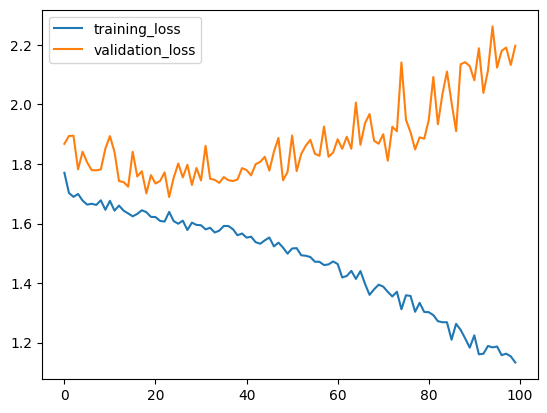

In [16]:
plt.plot(training_loss_history, label='training_loss')
plt.plot(validation_loss_history,label='validation_loss')
plt.legend()
plt.show

#### Plot the validation accuracy

<function matplotlib.pyplot.show(close=None, block=None)>

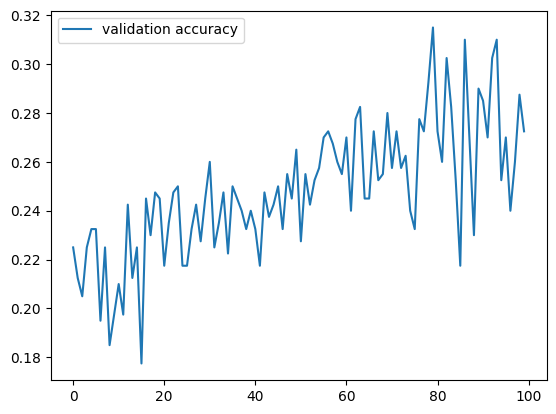

In [17]:
plt.plot(validation_accuracy_history, label='validation accuracy')
plt.legend()
plt.show